# Kinetic Mechanism Pathway Analyzer

Han, Kehang (hkh12@mit.edu)

This analyzer takes reaction ROP file (e.g. Chemkin ckcsv file), builds a reaction network, helps answer

- if the mechanism has certain pathway (from start species to end species)

- what is the biggest flux from/towards a certain species

In [1]:
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy.chemkin import loadChemkinFile
import os

In [2]:
# chemkin model name
mech = 'dbds_new'

In [3]:
path = os.path.abspath('../')
mechPath = path + '/data/' + mech
chemkinPath= mechPath + '/chem.inp'
dictionaryPath = mechPath + '/species_dictionary.txt'

model = CoreEdgeReactionModel()
model.core.species, model.core.reactions = loadChemkinFile(chemkinPath,dictionaryPath)

In [4]:
# generate paris for reactions that don't have flux pairs
for rxn in model.core.reactions:
    if not rxn.pairs: rxn.generatePairs()

## Create networkx Graph

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from extractInfoFromckcsv import getConcentrationDictFromCKCSV, getROPFromCKCSV, getFluxGraphEdgesDict
from rmgpy.chemkin import getSpeciesIdentifier
from IPython.display import display
import numpy as np
%matplotlib inline

### s1: prepare a dict for graph edges

In [20]:
ckcsvPath= mechPath + '/CKSoln.ckcsv'
firstColDict, spc_mf_dict = getConcentrationDictFromCKCSV(ckcsvPath)

first_col_dict, spc_total_rop_dict, spc_rop_dict = getROPFromCKCSV(ckcsvPath)

In [7]:
graph_edges_dict = getFluxGraphEdgesDict(spc_rop_dict, model.core.reactions)

In [8]:
graph_edges_dict_simple = {}
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    graph_edges_dict_simple[(node1, node2)] = graph_edges_dict[pair]

### s2: create DiGraph()

In [9]:
time_investigated = 0.1 # hour
timepoint_index = (np.abs(firstColDict['Time_(sec)']-time_investigated*3600)).argmin()
print "time is {0} secs".format(firstColDict['Time_(sec)'][timepoint_index])

time is 360.0 secs


In [10]:
G = nx.DiGraph()
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    e_rawdata = graph_edges_dict[pair]
    total_flux = 0
    for rxn in e_rawdata:
        total_flux += e_rawdata[rxn][timepoint_index]
    if total_flux >= 0:
        G.add_edge(node2, node1, {"total_flux":total_flux}) # in G, positive means production of node1
    else: 
        G.add_edge(node1, node2, {"total_flux":-total_flux}) # in G, negative means consumption of node1      

In [12]:
spc_mf_dict['DBDS(1)'][timepoint_index]

0.31259140000000002

### s3: find paths (with known target)

In [15]:
paths = list(nx.all_simple_paths(G, source="PDD(1)", target="RAD1(14)", cutoff=5))

#### sort out most sginificant path

In [35]:
path_fluxes = []
for i, path in enumerate(paths):
#     print i, path
    path_steps = len(path) - 1
    fluxes = [G[path[step]][path[step+1]]['total_flux'] for step in range(path_steps) ]
    path_fluxes.append(min(fluxes))
sorted_path_fluxes = sorted(path_fluxes)
print sorted_path_fluxes[-1], path_fluxes.index(sorted_path_fluxes[-1])

2.74504249953e-09 0


#### visualize the path of interest



**********Step0: PDD(5) --> C18H29(19): 2.74504249953e-09*************


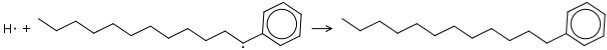

rxn#9605: [H](314) + CCCCCCCCCCC[CH]c1ccccc1(19) <=> PDD(5)


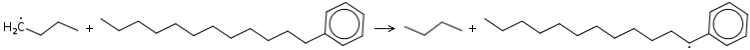

rxn#304(1/69 H_Abs): BUTYL(184) + PDD(5) <=> C4(165) + CCCCCCCCCCC[CH]c1ccccc1(19)


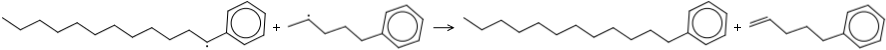

rxn#2152(1/28 Disp): CCCCCCCCCCC[CH]c1ccccc1(19) + C[CH]CCCc1ccccc1(275) <=> PDD(5) + A5ene(202)


In [36]:
path = paths[0]
path_steps = len(path) - 1
for step in range(path_steps):
    step_pair = (path[step], path[step+1])
    h_abs_rxns = []
    disp_rxns = []
    
    print "\n"
    print "**********Step{0}: {1} --> {2}: {3}*************".\
    format(step, step_pair[0], step_pair[1], G[step_pair[0]][step_pair[1]]['total_flux'])
    if step_pair not in graph_edges_dict_simple:
        step_pair = (step_pair[1], step_pair[0])
                
    for rxn in graph_edges_dict_simple[step_pair]:
        if rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            display(rxn)
            print "rxn#{0}: ".format(rxn.index) + str(rxn)
    if len(h_abs_rxns) > 0: 
        display(h_abs_rxns[0])
        print "rxn#{0}(1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) + str(h_abs_rxns[0])
    if len(disp_rxns) > 0: 
        display(disp_rxns[0])
        print "rxn#{0}(1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) + str(disp_rxns[0])

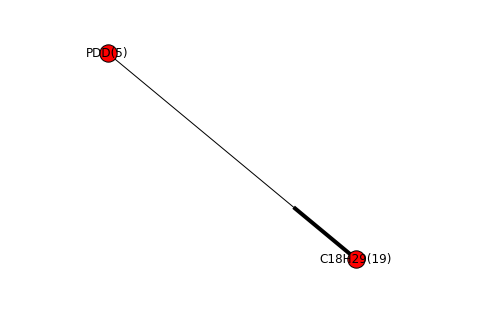

In [37]:
newG = G.subgraph(paths[0])
nx.draw(newG, with_labels=True)

### s4: find major decomposition paths (without known targets)

In [15]:
source = "DBDS(1)"
# print "total product flux for {0} is {1}.".format(source, spc_total_rop_dict[source][1][timepoint_index])
depth = 1
current_node = source
path_top_list = [0, 0, 0, 0, 0, 0, 0, 0]
for step in range(depth):
    print "\n"    
    nextNode_flux_list = [(next_node, G[current_node][next_node]['total_flux']) for next_node in G[current_node]]
    sorted_nextNode_flux_list = sorted(nextNode_flux_list, key=lambda tup: -tup[1])
    
    # choose the top one as next node
    tup = sorted_nextNode_flux_list[path_top_list[step]]
    next_node = tup[0]
    step_flux = tup[1]
    
    print "**********Step{0}: {1} --> {2}: {3} mol/cm3/s*************".\
    format(step, current_node, next_node, step_flux)
    
    step_pair = (current_node, next_node)
    if step_pair not in graph_edges_dict_simple:
        step_pair = (next_node, current_node)
    
    h_abs_rxns = []
    disp_rxns = []
    for rxn in graph_edges_dict_simple[step_pair]:
        if rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            display(rxn)
            print rxn.family
            print "rxn#{0}: {1}: {2} ".format(rxn.index, str(rxn), graph_edges_dict_simple[step_pair][rxn][timepoint_index])
    if len(h_abs_rxns) > 0: 
        display(h_abs_rxns[0])
        print "rxn#{0}(1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) + str(h_abs_rxns[0])
    if len(disp_rxns) > 0: 
        display(disp_rxns[0])
        print "rxn#{0}(1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) + str(disp_rxns[0])
    
    current_node = next_node



**********Step0: DBDS(1) --> S(56): 0 mol/cm3/s*************


('EBZYL2(60)', 'STYRENE(3)')
**********************************************************************************


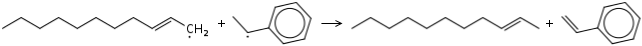

rxn#1614: C=C[CH]CCCCCCCC(921) + EBZYL2(60) <=> CC=CCCCCCCCC(3354) + STYRENE(3): 1.047199e-10 
**********************************************************************************


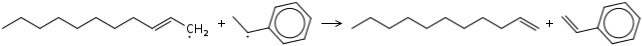

rxn#1480: C=C[CH]CCCCCCCC(921) + EBZYL2(60) <=> C11ene(46) + STYRENE(3): 1.057787e-10 
**********************************************************************************


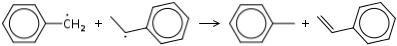

rxn#1107: BENZYL(58) + EBZYL2(60) <=> TOLUENE(2) + STYRENE(3): 2.608345e-10 
**********************************************************************************


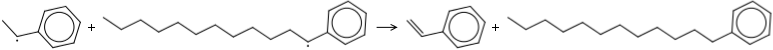

rxn#1092: EBZYL2(60) + RAD1(14) <=> STYRENE(3) + PDD(1): 6.506006e-10 
**********************************************************************************


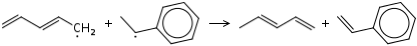

rxn#6577: [CH2]C=CC=C(17406) + EBZYL2(60) <=> C=CC=CC(3905) + STYRENE(3): 6.385398e-09 
***************************************
TOTAL flux from h_abs and disp is 7.5073317e-09.
92


In [35]:
print step_pair

total_flux = 0
rxn_flux_tups = []
for rxn in h_abs_rxns + disp_rxns:
    flux = graph_edges_dict_simple[step_pair][rxn][timepoint_index]
    
    rxn_flux_tups.append((rxn, flux))

rxn_flux_tups = sorted(rxn_flux_tups, key=lambda tup: tup[1], reverse=False)
for tup in rxn_flux_tups:
    rxn = tup[0]
    flux = tup[1]
    if flux > 0.1e-9:
        total_flux += flux
        print "**********************************************************************************"
        display(rxn) 
        print "rxn#{0}: {1}: {2} ".format(rxn.index, str(rxn), flux) # positive flux means production of pair node1
print "***************************************"
print "TOTAL flux from h_abs and disp is {0}.".format(total_flux)
print len(h_abs_rxns + disp_rxns)

### s5: find major generation paths (without known sources)

total product flux for A3yl(61) is 5.415701e-19.


**********Step0: A3yl(61) <-- BENZYL(58): 7.369363e-10*************


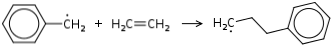

rxn#59: BENZYL(58) + C2ene(37) <=> A3yl(61)


**********Step1: BENZYL(58) <-- RAD3(16): 2.332901e-08*************


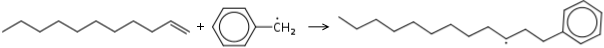

rxn#34: C11ene(46) + BENZYL(58) <=> RAD3(16)


In [42]:
target = "A3yl(61)"
print "total product flux for {0} is {1}.".format(target, spc_total_rop_dict[target][1][timepoint_index])
depth = 2
current_node = target
path_top_list = [1, 0, 0, 0, 0]
for step in range(depth):
    print "\n"
    prev_nodes = []
    for node1 in G:
        if current_node in G[node1]:
            prev_nodes.append(node1)
    prevNode_flux_list = [(prev_node, G[prev_node][current_node]['total_flux']) for prev_node in prev_nodes]
    sorted_prevNode_flux_list = sorted(prevNode_flux_list, key=lambda tup: -tup[1])
    
    # choose the top one as next node
    tup = sorted_prevNode_flux_list[path_top_list[step]]
    prev_node = tup[0]
    step_flux = tup[1]
    
    print "**********Step{0}: {1} <-- {2}: {3}*************".\
    format(step, current_node, prev_node, step_flux)
    
    step_pair = (prev_node, current_node)
    if step_pair not in graph_edges_dict_simple:
        step_pair = (current_node, prev_node)
    
    h_abs_rxns = []
    disp_rxns = []
    for rxn in graph_edges_dict_simple[step_pair]:
        if rxn.family == "H_Abstraction":
            h_abs_rxns.append(rxn)
        elif rxn.family == "Disproportionation":
            disp_rxns.append(rxn)
        else:
            display(rxn)
            print "rxn#{0}: ".format(rxn.index) + str(rxn)
    if len(h_abs_rxns) > 0: 
        display(h_abs_rxns[0])
        print "rxn#{0}(1/{1} H_Abs): ".format(h_abs_rxns[0].index, len(h_abs_rxns)) + str(h_abs_rxns[0])
    if len(disp_rxns) > 0: 
        display(disp_rxns[0])
        print "rxn#{0}(1/{1} Disp): ".format(disp_rxns[0].index, len(disp_rxns)) + str(disp_rxns[0])
    
    current_node = prev_node

('UDECYL(57)', 'C11ene(46)')
**********************************************************************************


rxn#6597: UDECYL(57) + [CH2]C=CC=C(10652) <=> C11ene(46) + C=CC=CC(3332): 4.341768e-11 
**********************************************************************************


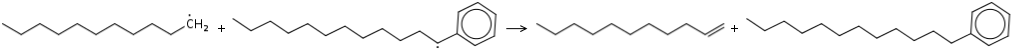

rxn#374: UDECYL(57) + RAD1(14) <=> C11ene(46) + PDD(1): 7.873254e-12 
**********************************************************************************


rxn#1503: UDECYL(57) + C=C[CH]CCCCCCCC(921) <=> C11ene(46) + C11ene(46): 1.383297e-12 
**********************************************************************************


rxn#1677: UDECYL(57) + CC=C[CH]CCCCCCC(3211) <=> C11ene(46) + CC=CCCCCCCCC(3039): 1.021742e-12 
**********************************************************************************


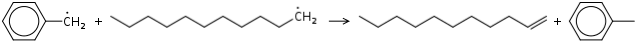

rxn#938: BENZYL(58) + UDECYL(57) <=> C11ene(46) + TOLUENE(2): 8.751374e-13 
**********************************************************************************


rxn#1840: UDECYL(57) + CCC=C[CH]CCCCCC(3431) <=> C11ene(46) + CCC=CCCCCCCC(3336): 8.292693e-13 
**********************************************************************************


rxn#1766: UDECYL(57) + CC=C[CH]CCCCCCC(3211) <=> C11ene(46) + CCC=CCCCCCCC(3336): 7.891792e-13 
**********************************************************************************


rxn#2160: UDECYL(57) + CCCC=C[CH]CCCCC(3741) <=> C11ene(46) + CCCC=CCCCCCC(3628): 6.975715e-13 
**********************************************************************************


rxn#2008: UDECYL(57) + CCC=C[CH]CCCCCC(3431) <=> C11ene(46) + CCCC=CCCCCCC(3628): 6.970283e-13 
**********************************************************************************


rxn#1634: UDECYL(57) + C=C[CH]CCCCCCCC(921) <=> C11ene(46) + CC=CCCCCCCCC(3039): 6.59195e-13 
**********************************************************************************


rxn#2649: UDECYL(57) + CCCC[CH]C=CCCCC(4291) <=> C11ene(46) + CCCCC=CCCCCC(4082): 6.317758e-13 
**********************************************************************************


rxn#2328: UDECYL(57) + CCCC=C[CH]CCCCC(3741) <=> C11ene(46) + CCCCC=CCCCCC(4082): 6.31595e-13 
**********************************************************************************


rxn#5218: UDECYL(57) + C[CH]C=CC(4079) <=> C11ene(46) + CC=CCC(3860): 4.171641e-13 
**********************************************************************************


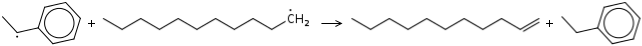

rxn#1170: EBZYL2(60) + UDECYL(57) <=> C11ene(46) + ETHBENZ(4): 3.944468e-13 
**********************************************************************************


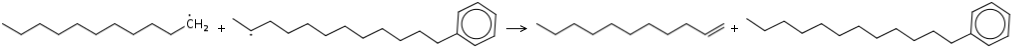

rxn#564: UDECYL(57) + RAD11(24) <=> C11ene(46) + PDD(1): 3.560742e-13 
**********************************************************************************


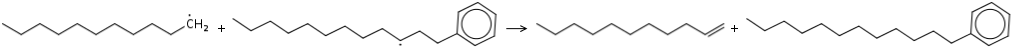

rxn#412: UDECYL(57) + RAD3(16) <=> C11ene(46) + PDD(1): 3.045213e-13 
**********************************************************************************


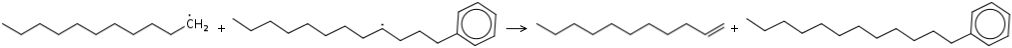

rxn#431: UDECYL(57) + RAD4(17) <=> C11ene(46) + PDD(1): 3.042245e-13 
**********************************************************************************


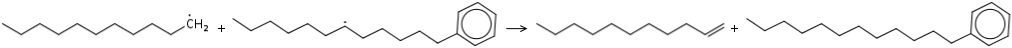

rxn#469: UDECYL(57) + RAD6(19) <=> C11ene(46) + PDD(1): 3.042244e-13 
**********************************************************************************


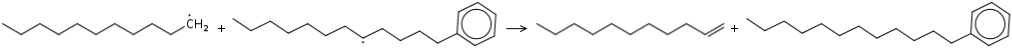

rxn#450: UDECYL(57) + RAD5(18) <=> C11ene(46) + PDD(1): 3.042244e-13 
**********************************************************************************


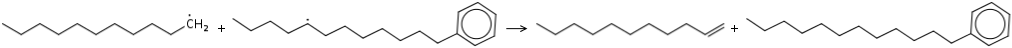

rxn#507: UDECYL(57) + RAD8(21) <=> C11ene(46) + PDD(1): 3.042183e-13 
**********************************************************************************


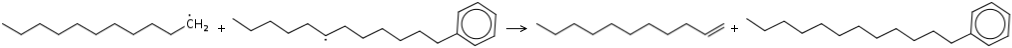

rxn#488: UDECYL(57) + RAD7(20) <=> C11ene(46) + PDD(1): 3.042176e-13 
**********************************************************************************


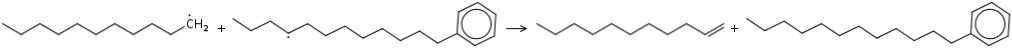

rxn#526: UDECYL(57) + RAD9(22) <=> C11ene(46) + PDD(1): 3.042166e-13 
**********************************************************************************


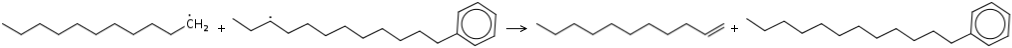

rxn#545: UDECYL(57) + RAD10(23) <=> C11ene(46) + PDD(1): 3.042018e-13 
**********************************************************************************


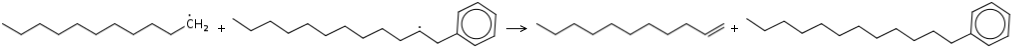

rxn#393: UDECYL(57) + RAD2(15) <=> C11ene(46) + PDD(1): 3.041884e-13 
**********************************************************************************


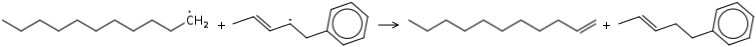

rxn#7156: UDECYL(57) + CC=C[CH]Cc1ccccc1(7408) <=> C11ene(46) + CC=CCCc1ccccc1(5398): 2.854769e-13 
**********************************************************************************


rxn#2259: UDECYL(57) + C=C[CH]CC(870) <=> C11ene(46) + CC=CCC(3860): 2.704903e-13 
**********************************************************************************


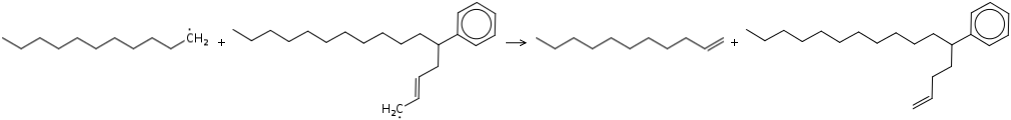

rxn#3086: UDECYL(57) + C=C[CH]CC(CCCCCCCCCCC)c1ccccc1(5586) <=> C11ene(46) + C=CCCC(CCCCCCCCCCC)c1ccccc1(5784): 2.275519e-13 
**********************************************************************************


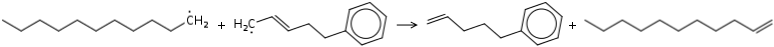

rxn#2952: UDECYL(57) + C=C[CH]CCc1ccccc1(940) <=> A5ene(71) + C11ene(46): 1.954023e-13 
**********************************************************************************


rxn#4817: UDECYL(57) + CC=C[CH]CC(4857) <=> C11ene(46) + CC=CCCC(4706): 1.87658e-13 
**********************************************************************************


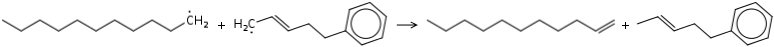

rxn#4026: UDECYL(57) + C=C[CH]CCc1ccccc1(940) <=> C11ene(46) + CC=CCCc1ccccc1(5398): 1.849644e-13 
**********************************************************************************


rxn#5083: UDECYL(57) + CC=C[CH]CC(4857) <=> C11ene(46) + CCC=CCC(8587): 1.793054e-13 
**********************************************************************************


rxn#4431: UDECYL(57) + CC=C[CH]CCC(4559) <=> C11ene(46) + CC=CCCCC(4417): 1.472992e-13 
**********************************************************************************


rxn#5829: UDECYL(57) + CC=C[CH]CCCCC(5202) <=> C11ene(46) + CC=CCCCCCC(5041): 1.47183e-13 
**********************************************************************************


rxn#5424: UDECYL(57) + CC=C[CH]CCCC(6554) <=> C11ene(46) + CC=CCCCCC(6284): 1.454464e-13 
**********************************************************************************


rxn#6069: UDECYL(57) + CC=C[CH]CCCCCC(6279) <=> C11ene(46) + CC=CCCCCCCC(6102): 1.431822e-13 
**********************************************************************************


rxn#4686: UDECYL(57) + CC=C[CH]CCC(4559) <=> C11ene(46) + CCC=CCCC(8117): 1.353076e-13 
**********************************************************************************


rxn#6036: UDECYL(57) + CC=C[CH]CCCCC(5202) <=> C11ene(46) + CCC=CCCCCC(9742): 1.351811e-13 
**********************************************************************************


rxn#5709: UDECYL(57) + CC=C[CH]CCCC(6554) <=> C11ene(46) + CCC=CCCCC(9126): 1.335284e-13 
**********************************************************************************


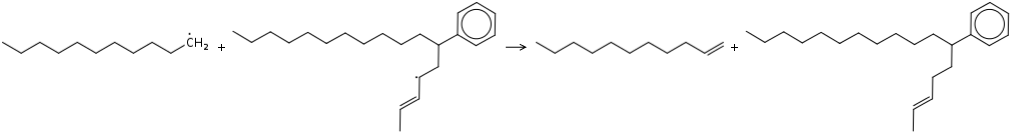

rxn#7499: UDECYL(57) + CC=C[CH]CC(CCCCCCCCCCC)c1ccccc1(10660) <=> C11ene(46) + CC=CCCC(CCCCCCCCCCC)c1ccccc1(11110): 1.310991e-13 
**********************************************************************************


rxn#6259: UDECYL(57) + CC=C[CH]CCCCCC(6279) <=> C11ene(46) + CCC=CCCCCCC(10104): 1.308631e-13 
**********************************************************************************


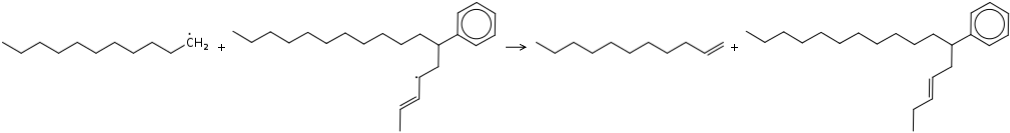

rxn#6901: UDECYL(57) + CC=C[CH]CC(CCCCCCCCCCC)c1ccccc1(10660) <=> C11ene(46) + CCC=CCC(CCCCCCCCCCC)c1ccccc1(11111): 1.289983e-13 
**********************************************************************************


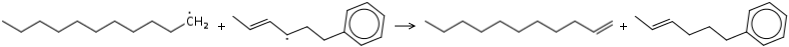

rxn#6292: UDECYL(57) + CC=C[CH]CCc1ccccc1(6866) <=> C11ene(46) + CC=CCCCc1ccccc1(6564): 1.235602e-13 
**********************************************************************************


rxn#2764: UDECYL(57) + C=C[CH]CCC(876) <=> C11ene(46) + CC=CCCC(4706): 1.215269e-13 
**********************************************************************************


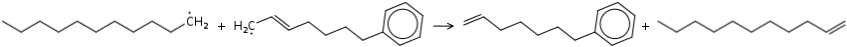

rxn#3534: UDECYL(57) + C=C[CH]CCCCc1ccccc1(959) <=> A7ene(73) + C11ene(46): 1.206784e-13 
**********************************************************************************


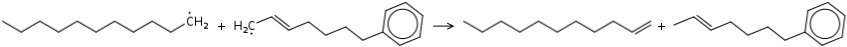

rxn#3838: UDECYL(57) + C=C[CH]CCCCc1ccccc1(959) <=> C11ene(46) + CC=CCCCCc1ccccc1(6872): 1.192793e-13 
**********************************************************************************


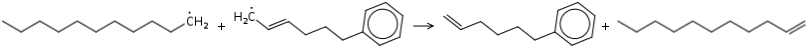

rxn#3427: UDECYL(57) + C=C[CH]CCCc1ccccc1(949) <=> A6ene(72) + C11ene(46): 1.140557e-13 
**********************************************************************************


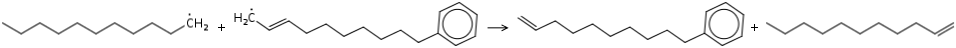

rxn#7889: UDECYL(57) + C=C[CH]CCCCCCCc1ccccc1(995) <=> A10ene(76) + C11ene(46): 1.048717e-13 
**********************************************************************************


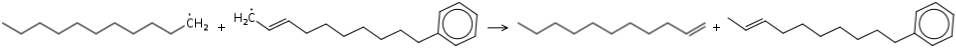

rxn#8110: UDECYL(57) + C=C[CH]CCCCCCCc1ccccc1(995) <=> C11ene(46) + CC=CCCCCCCCc1ccccc1(18030): 1.036719e-13 
**********************************************************************************


rxn#2532: UDECYL(57) + C=C[CH]CCCC(883) <=> C11ene(46) + CC=CCCCC(4417): 9.529483e-14 
**********************************************************************************


rxn#2919: UDECYL(57) + C=C[CH]CCCCCC(900) <=> C11ene(46) + CC=CCCCCCC(5041): 9.468109e-14 
**********************************************************************************


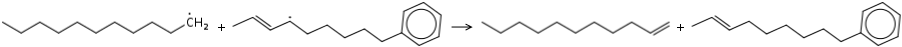

rxn#8382: UDECYL(57) + CC=C[CH]CCCCCc1ccccc1(7867) <=> C11ene(46) + CC=CCCCCCCc1ccccc1(7657): 9.459907e-14 
**********************************************************************************


rxn#3500: UDECYL(57) + C=C[CH]CCCCC(891) <=> C11ene(46) + CC=CCCCCC(6284): 9.40101e-14 
**********************************************************************************


rxn#3333: UDECYL(57) + C=C[CH]CCCCCCC(910) <=> C11ene(46) + CC=CCCCCCCC(6102): 9.25991e-14 
**********************************************************************************


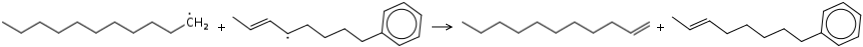

rxn#8894: UDECYL(57) + CC=C[CH]CCCCc1ccccc1(10779) <=> C11ene(46) + CC=CCCCCCc1ccccc1(15747): 8.970898e-14 
**********************************************************************************


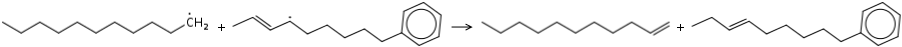

rxn#8611: UDECYL(57) + CC=C[CH]CCCCCc1ccccc1(7867) <=> C11ene(46) + CCC=CCCCCCc1ccccc1(19526): 8.665512e-14 
**********************************************************************************


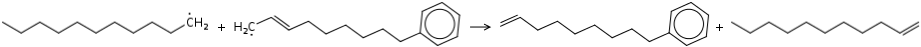

rxn#4059: UDECYL(57) + C=C[CH]CCCCCCc1ccccc1(982) <=> A9ene(75) + C11ene(46): 8.33656e-14 
**********************************************************************************


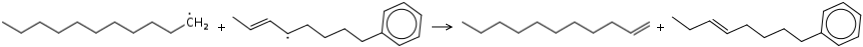

rxn#9131: UDECYL(57) + CC=C[CH]CCCCc1ccccc1(10779) <=> C11ene(46) + CCC=CCCCCc1ccccc1(21023): 8.222234e-14 
**********************************************************************************


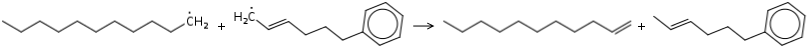

rxn#3672: UDECYL(57) + C=C[CH]CCCc1ccccc1(949) <=> C11ene(46) + CC=CCCCc1ccccc1(6564): 7.996119e-14 
**********************************************************************************


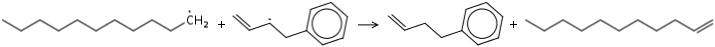

rxn#5528: UDECYL(57) + C=C[CH]Cc1ccccc1(932) <=> A4ene(70) + C11ene(46): 7.966019e-14 
**********************************************************************************


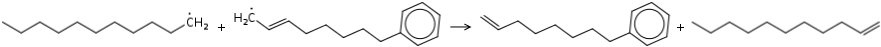

rxn#7285: UDECYL(57) + C=C[CH]CCCCCc1ccccc1(970) <=> A8ene(74) + C11ene(46): 7.874154e-14 
**********************************************************************************


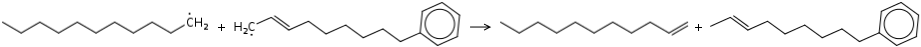

rxn#4304: UDECYL(57) + C=C[CH]CCCCCCc1ccccc1(982) <=> C11ene(46) + CC=CCCCCCCc1ccccc1(7657): 6.119798e-14 
**********************************************************************************


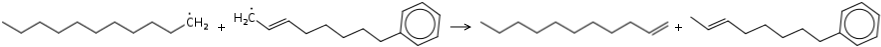

rxn#7851: UDECYL(57) + C=C[CH]CCCCCc1ccccc1(970) <=> C11ene(46) + CC=CCCCCCc1ccccc1(15747): 5.804717e-14 
**********************************************************************************


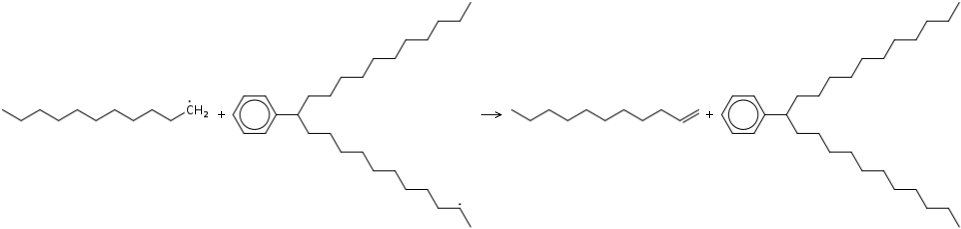

rxn#3948: UDECYL(57) + C[CH]CCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(3194) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(217): 4.643406e-14 
**********************************************************************************


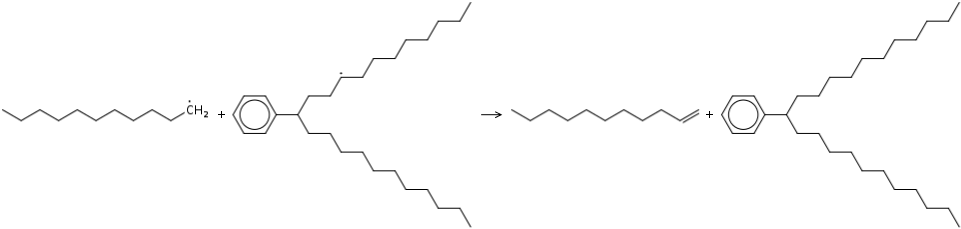

rxn#4152: UDECYL(57) + CCCCCCCC[CH]CCC(CCCCCCCCCCC)c1ccccc1(3192) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(217): 3.972632e-14 
**********************************************************************************


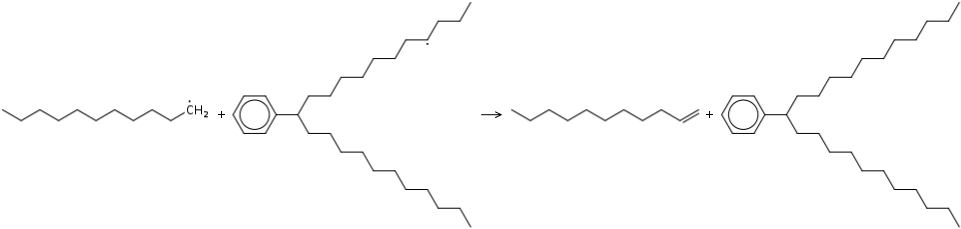

rxn#4525: UDECYL(57) + CCC[CH]CCCCCCCC(CCCCCCCCCCC)c1ccccc1(3183) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(217): 3.972452e-14 
**********************************************************************************


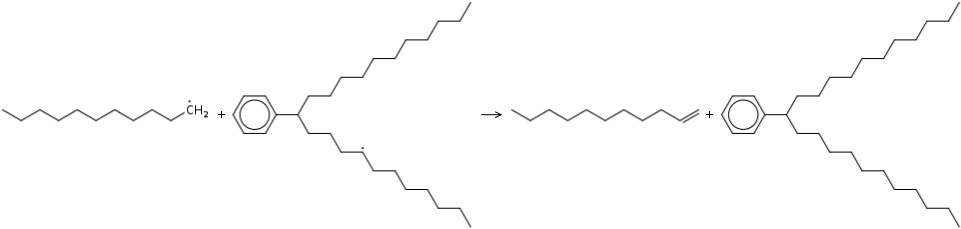

rxn#5320: UDECYL(57) + CCCCCCC[CH]CCCC(CCCCCCCCCCC)c1ccccc1(3191) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(217): 3.972452e-14 
**********************************************************************************


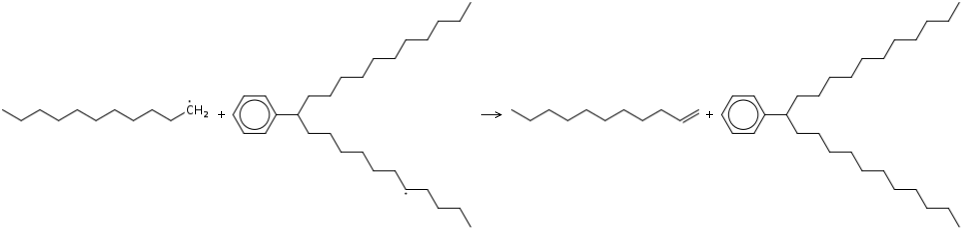

rxn#4719: UDECYL(57) + CCCC[CH]CCCCCCC(CCCCCCCCCCC)c1ccccc1(3185) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(217): 3.972452e-14 
**********************************************************************************


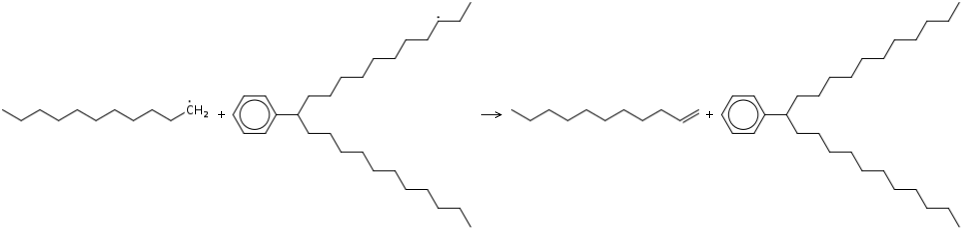

rxn#4337: UDECYL(57) + CC[CH]CCCCCCCCC(CCCCCCCCCCC)c1ccccc1(3181) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(217): 3.972452e-14 
**********************************************************************************


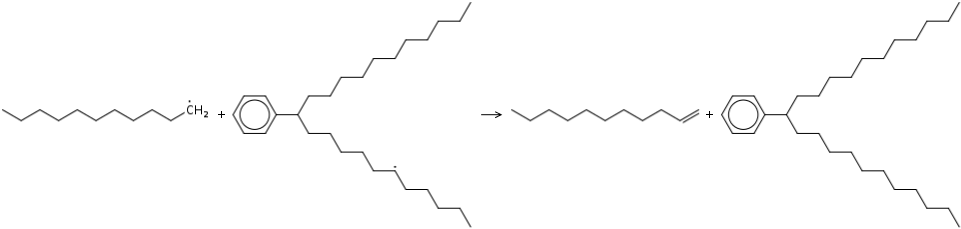

rxn#4915: UDECYL(57) + CCCCC[CH]CCCCCC(CCCCCCCCCCC)c1ccccc1(3187) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(217): 3.972452e-14 
**********************************************************************************


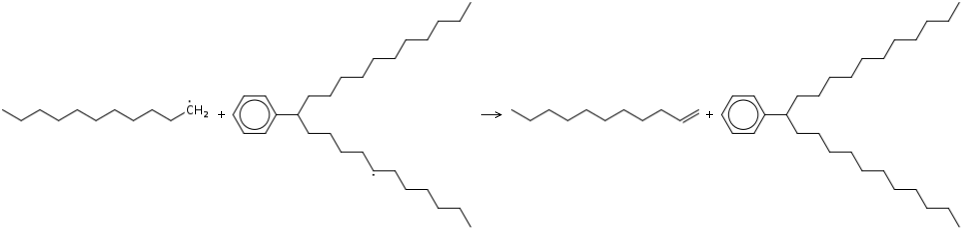

rxn#5116: UDECYL(57) + CCCCCC[CH]CCCCC(CCCCCCCCCCC)c1ccccc1(3189) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(217): 3.972452e-14 
**********************************************************************************


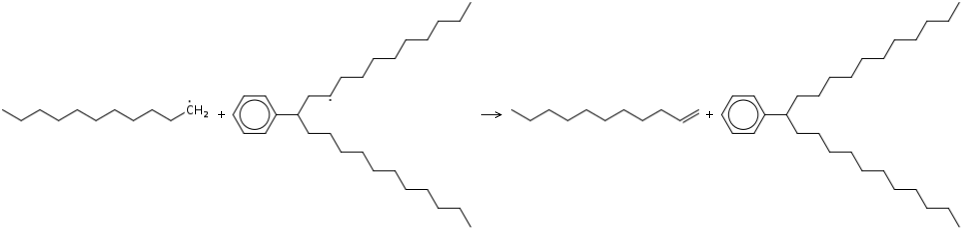

rxn#1633: UDECYL(57) + CCCCCCCCC[CH]CC(CCCCCCCCCCC)c1ccccc1(1283) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(217): 3.969197e-14 
**********************************************************************************


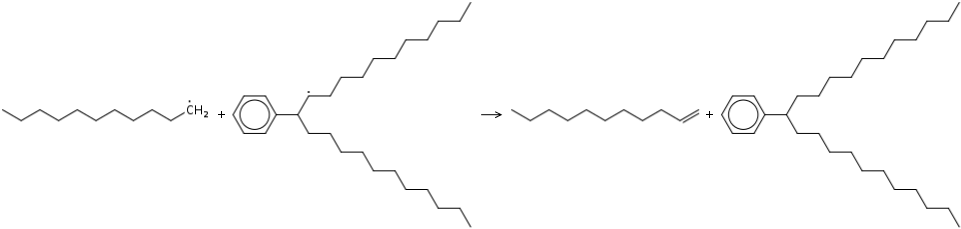

rxn#8147: UDECYL(57) + CCCCCCCCCC[CH]C(CCCCCCCCCCC)c1ccccc1(3178) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCCCCC)c1ccccc1(217): 3.400435e-14 
**********************************************************************************


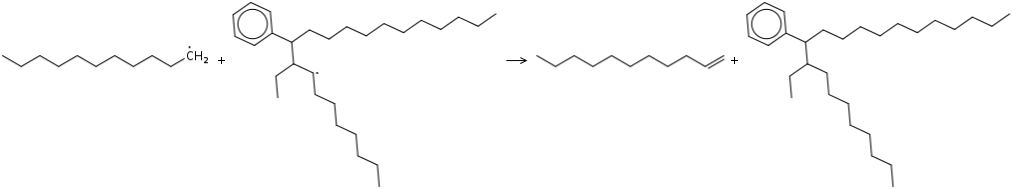

rxn#8759: UDECYL(57) + CCCCCCC[CH]C(CC)C(CCCCCCCCCCC)c1ccccc1(3444) <=> C11ene(46) + CCCCCCCCCCCC(c1ccccc1)C(CC)CCCCCCCC(16737): 1.148585e-14 
**********************************************************************************


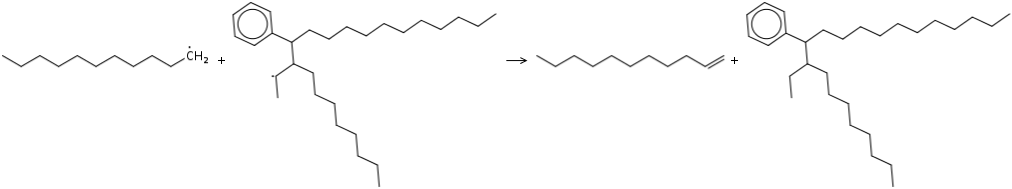

rxn#7625: UDECYL(57) + C[CH]C(CCCCCCCC)C(CCCCCCCCCCC)c1ccccc1(3225) <=> C11ene(46) + CCCCCCCCCCCC(c1ccccc1)C(CC)CCCCCCCC(16737): 1.147241e-14 
**********************************************************************************


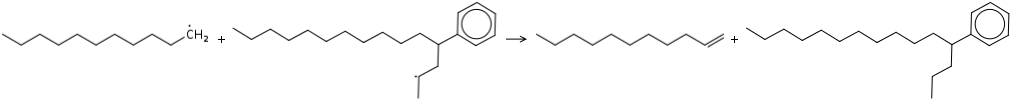

rxn#2533: UDECYL(57) + C[CH]CC(CCCCCCCCCCC)c1ccccc1(1235) <=> C11ene(46) + CCCCCCCCCCCC(CCC)c1ccccc1(193): 9.412384e-15 
**********************************************************************************


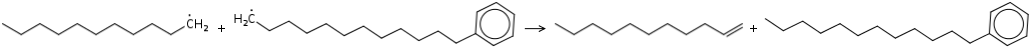

rxn#583: UDECYL(57) + RAD12(25) <=> C11ene(46) + PDD(1): 6.71533e-15 
**********************************************************************************


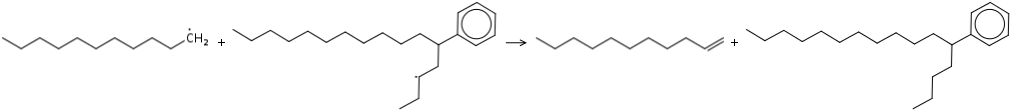

rxn#7065: UDECYL(57) + CC[CH]CC(CCCCCCCCCCC)c1ccccc1(1241) <=> C11ene(46) + CCCCCCCCCCCC(CCCC)c1ccccc1(196): 4.416644e-15 
**********************************************************************************


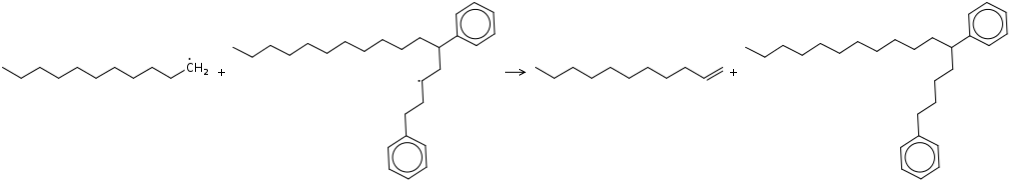

rxn#5924: UDECYL(57) + CCCCCCCCCCCC(C[CH]CCc1ccccc1)c1ccccc1(1295) <=> C11ene(46) + CCCCCCCCCCCC(CCCCc1ccccc1)c1ccccc1(235): 4.234251e-15 
**********************************************************************************


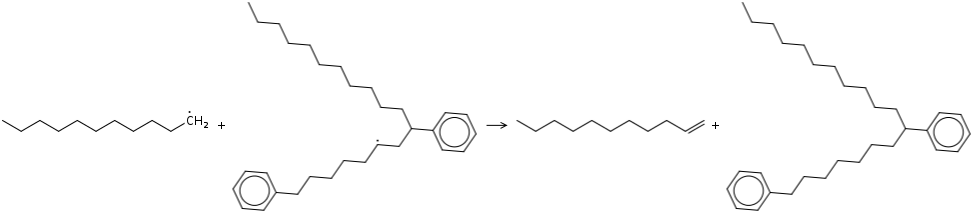

rxn#3839: UDECYL(57) + CCCCCCCCCCCC(C[CH]CCCCCc1ccccc1)c1ccccc1(1313) <=> C11ene(46) + CCCCCCCCCCCC(CCCCCCCc1ccccc1)c1ccccc1(244): 2.605267e-15 
**********************************************************************************


rxn#796: HEXYL(52) + UDECYL(57) <=> C6(31) + C11ene(46): 5.51898e-16 
**********************************************************************************


rxn#914: UDECYL(57) + DECYL(56) <=> C10(35) + C11ene(46): 4.21925e-16 
**********************************************************************************


rxn#830: HEPTYL(53) + UDECYL(57) <=> C7(32) + C11ene(46): 4.049669e-16 
**********************************************************************************


rxn#759: PENTYL(51) + UDECYL(57) <=> C5(30) + C11ene(46): 3.588355e-16 
**********************************************************************************


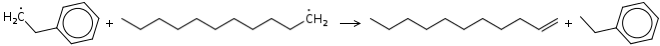

rxn#940: EBZYL(59) + UDECYL(57) <=> C11ene(46) + ETHBENZ(4): 3.305904e-16 
**********************************************************************************


rxn#861: OCTYL(54) + UDECYL(57) <=> C8(33) + C11ene(46): 2.604677e-16 
**********************************************************************************


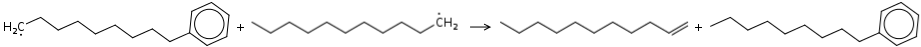

rxn#954: A9yl(67) + UDECYL(57) <=> C11ene(46) + BENZ9(11): 2.322033e-16 
**********************************************************************************


rxn#618: UDECYL(57) + ETHYL(48) <=> C2(27) + C11ene(46): 1.906088e-16 
**********************************************************************************


rxn#717: BUTYL(50) + UDECYL(57) <=> C4(29) + C11ene(46): 1.77274e-16 
**********************************************************************************


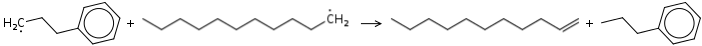

rxn#942: A3yl(61) + UDECYL(57) <=> C11ene(46) + BENZ3(5): 1.71921e-16 
**********************************************************************************


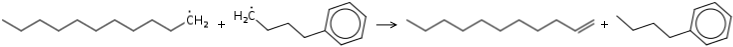

rxn#944: UDECYL(57) + A4yl(62) <=> C11ene(46) + BENZ4(6): 1.702451e-16 
**********************************************************************************


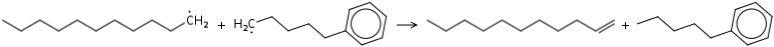

rxn#946: UDECYL(57) + A5yl(63) <=> C11ene(46) + BENZ5(7): 1.640625e-16 
**********************************************************************************


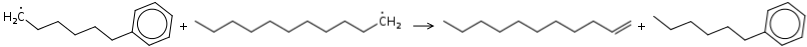

rxn#948: A6yl(64) + UDECYL(57) <=> C11ene(46) + BENZ6(8): 1.639762e-16 
**********************************************************************************


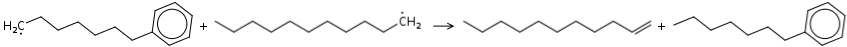

rxn#950: A7yl(65) + UDECYL(57) <=> C11ene(46) + BENZ7(9): 1.637808e-16 
**********************************************************************************


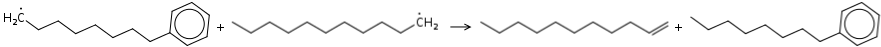

rxn#952: A8yl(66) + UDECYL(57) <=> C11ene(46) + BENZ8(10): 1.238911e-16 
**********************************************************************************


rxn#670: UDECYL(57) + PROPYL(49) <=> C3(28) + C11ene(46): 7.804892e-17 
**********************************************************************************


rxn#937: UDECYL(57) + UDECYL(57) <=> C11(36) + C11ene(46): 3.339947e-17 
**********************************************************************************


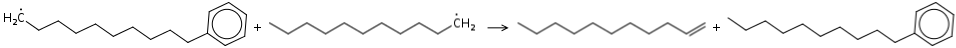

rxn#956: A10yl(68) + UDECYL(57) <=> C11ene(46) + BENZ10(12): 9.890287e-18 
**********************************************************************************


rxn#889: UDECYL(57) + NONYL(55) <=> C9(34) + C11ene(46): 6.335689e-18 
**********************************************************************************


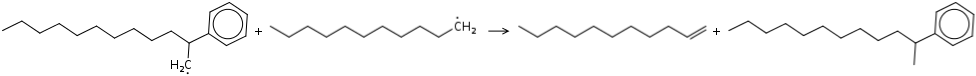

rxn#1890: PDDJ2(77) + UDECYL(57) <=> C11ene(46) + CCCCCCCCCCC(C)c1ccccc1(2386): 2.579908e-18 
**********************************************************************************


rxn#1405: UDECYL(57) + METHYL(47) <=> C1(26) + C11ene(46): 2.555304e-19 
**********************************************************************************


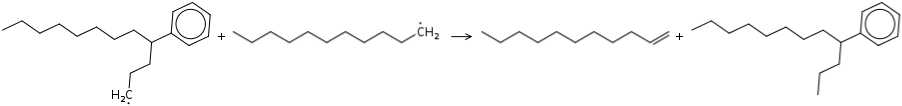

rxn#1464: PDDJ4(79) + UDECYL(57) <=> C11ene(46) + CCCCCCCCC(CCC)c1ccccc1(2684): 4.268846e-20 
**********************************************************************************


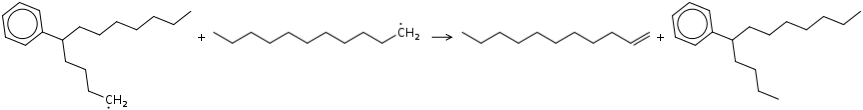

rxn#2007: PDDJ5(80) + UDECYL(57) <=> C11ene(46) + CCCCCCCC(CCCC)c1ccccc1(3441): 1.95972e-22 
***************************************
TOTAL flux from h_abs and disp is 6.8752536055e-11.


In [60]:
print step_pair
total_flux = 0
rxn_flux_tups = []
for rxn in h_abs_rxns + disp_rxns:
    flux = graph_edges_dict_simple[step_pair][rxn][timepoint_index]
    
    rxn_flux_tups.append((rxn, flux))

rxn_flux_tups = sorted(rxn_flux_tups, key=lambda tup: tup[1], reverse=True)
for tup in rxn_flux_tups:
    rxn = tup[0]
    flux = tup[1]
    if abs(flux) > 0e-9:
        total_flux += flux
        print "**********************************************************************************"
        display(rxn) 
        print "rxn#{0}: {1}: {2} ".format(rxn.index, str(rxn), flux) # positive flux means production of pair node1
print "***************************************"
print "TOTAL flux from h_abs and disp is {0}.".format(total_flux)